In [3]:
import os, glob, copy
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from torchvision.models import resnet50, ResNet50_Weights
from tqdm import tqdm
import matplotlib.pyplot as plt
import random

In [4]:
# Build label mapping
def build_class_mapping(label_file):
    class_set = set()
    with open(label_file, 'r') as f:
        for line in f:
            _, class_name = line.strip().split(',')
            class_set.add(class_name)
    sorted_classes = sorted(class_set)
    class_to_idx = {name: idx for idx, name in enumerate(sorted_classes)}
    return class_to_idx

# Custom Dataset
class SportsDataset(Dataset):
    def __init__(self, root_dir, split='train', transform=None, class_to_idx=None):
        self.image_dir = os.path.join(root_dir, split, 'images')
        label_file = os.path.join(root_dir, split, 'labels.txt')
        self.transform = transform
        self.image_paths = []
        self.labels = []
        self.class_to_idx = class_to_idx or {}

        with open(label_file, 'r') as f:
            for line in f:
                image_name, class_name = line.strip().split(',')
                if class_name not in self.class_to_idx:
                    self.class_to_idx[class_name] = len(self.class_to_idx)
                self.image_paths.append(os.path.join(self.image_dir, image_name))
                self.labels.append(self.class_to_idx[class_name])

        self.idx_to_class = {v: k for k, v in self.class_to_idx.items()}

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('RGB')
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# Transforms
def get_transforms():
    train_transform = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    test_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    return train_transform, test_transform

# Dataloaders
def get_dataloaders(root_dir, class_to_idx, batch_size=64):
    train_t, test_t = get_transforms()
    train_ds = SportsDataset(root_dir, 'train', transform=train_t, class_to_idx=class_to_idx)
    val_ds   = SportsDataset(root_dir, 'val', transform=test_t, class_to_idx=class_to_idx)
    test_ds  = SportsDataset(root_dir, 'test', transform=test_t, class_to_idx=class_to_idx)

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
    val_loader   = DataLoader(val_ds, batch_size=batch_size, num_workers=4, pin_memory=True)
    test_loader  = DataLoader(test_ds, batch_size=batch_size, num_workers=4, pin_memory=True)
    return train_loader, val_loader, test_loader

# Model
def build_model(num_classes):
    weights = ResNet50_Weights.DEFAULT
    model = resnet50(weights=weights)
    for param in model.parameters():
        param.requires_grad = False
    for param in model.layer4.parameters():
        param.requires_grad = True
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model

# Train
def train_model(model, train_loader, val_loader, device, epochs=10, lr=1e-4, save_path='best_model.pth'):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)
    best_acc = 0.0
    best_weights = copy.deepcopy(model.state_dict())

    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")
        model.train()
        running_loss, running_corrects = 0.0, 0

        for inputs, labels in tqdm(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)
        print(f"Train Loss: {epoch_loss:.4f} | Acc: {epoch_acc:.4f}")

        # Validation
        model.eval()
        all_preds, all_labels = [], []
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        val_acc = accuracy_score(all_labels, all_preds)
        print(f"Val Acc: {val_acc:.4f}")
        if val_acc > best_acc:
            best_acc = val_acc
            best_weights = copy.deepcopy(model.state_dict())
            torch.save(best_weights, save_path)
            print("✅ Best model saved.")

    model.load_state_dict(best_weights)
    return model

# Evaluate
# def evaluate_model(model, test_loader, device, class_names=None):
#     model.eval()
#     all_preds, all_labels = [], []

#     with torch.no_grad():
#         for inputs, labels in test_loader:
#             inputs, labels = inputs.to(device), labels.to(device)
#             outputs = model(inputs)
#             _, preds = torch.max(outputs, 1)
#             all_preds.extend(preds.cpu().numpy())
#             all_labels.extend(labels.cpu().numpy())

#     acc = accuracy_score(all_labels, all_preds)
#     precision = precision_score(all_labels, all_preds, average='macro')
#     recall = recall_score(all_labels, all_preds, average='macro')
#     f1 = f1_score(all_labels, all_preds, average='macro')

#     print("\n=== Test Results ===")
#     print(f"Accuracy :  {acc:.4f}")
#     print(f"Precision:  {precision:.4f}")
#     print(f"Recall   :  {recall:.4f}")
#     print(f"F1 Score :  {f1:.4f}")

def evaluate_model(model, test_loader, device, class_names=None, show_misclassified=True, max_misclassified=24):
    model.eval()
    all_preds, all_labels = [], []
    misclassified = []  

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
            if show_misclassified and class_names is not None:
                for i in range(len(labels)):
                    if preds[i] != labels[i]:
                        misclassified.append((
                            inputs[i].detach().cpu(),
                            preds[i].item(),
                            labels[i].item()
                        ))
        
    # Tính toán các metric
    acc = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='macro')
    recall = recall_score(all_labels, all_preds, average='macro')
    f1 = f1_score(all_labels, all_preds, average='macro')
    
    print("\n=== Test Results ===")
    print(f"Accuracy :  {acc:.4f}")
    print(f"Precision:  {precision:.4f}")
    print(f"Recall   :  {recall:.4f}")
    print(f"F1 Score :  {f1:.4f}\n")
    
    print("=== Classification Report ===")
    print(classification_report(all_labels, all_preds, target_names=class_names if class_names else None))
    
    if class_names is not None:
        cm = confusion_matrix(all_labels, all_preds)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
        plt.figure(figsize=(12, 10))
        disp.plot(cmap='Blues', xticks_rotation=90)
        plt.title("Confusion Matrix", fontsize=16)
        plt.tight_layout()
        plt.show()
    
    if show_misclassified and class_names is not None and misclassified:
        if len(misclassified) > max_misclassified:
            misclassified = random.sample(misclassified, max_misclassified)
        n_images = len(misclassified)
        # Grid cố định: 6 hàng, 4 cột (tổng 24 ô)
        rows, cols = 6, 4
        plt.figure(figsize=(4 * cols, 4 * rows))
        for i in range(n_images):
            img, pred, true = misclassified[i]
            img = img.permute(1, 2, 0).numpy() 
            img = (img - img.min()) / (img.max() - img.min() + 1e-5)  # scale về [0,1]
            ax = plt.subplot(rows, cols, i + 1)
            ax.imshow(img)
            ax.axis('off')
            ax.text(0.05, 1.02, f"True: {class_names[true]}", transform=ax.transAxes,
                    ha='left', va='bottom', color='blue', fontsize=9, fontweight='bold')
            ax.text(0.95, 1.02, f"Prid: {class_names[pred]}", transform=ax.transAxes,
                    ha='right', va='bottom', color='red', fontsize=9, fontweight='bold')
        plt.suptitle("Misclassified Samples", fontsize=22)
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()


In [5]:
# 1. Thiết lập
root_dir = '/kaggle/input/sport-img/dataset'
label_path = os.path.join(root_dir, 'train', 'labels.txt')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Đang sử dụng thiết bị:", device)

# Mapping và số lớp
class_to_idx = build_class_mapping(label_path)
idx_to_class = {v: k for k, v in class_to_idx.items()}
class_names = [idx_to_class[i] for i in range(len(idx_to_class))]
num_classes = len(class_to_idx)

# Load Data
train_loader, val_loader, test_loader = get_dataloaders(root_dir, class_to_idx, batch_size=128)

# Xây model
model = build_model(num_classes).to(device)

Đang sử dụng thiết bị: cuda


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 173MB/s] 


In [ ]:
model = train_model(
    model,
    train_loader,
    val_loader,
    device,
    epochs=15,
    save_path='best_model.pth'
)


Epoch 1/15


100%|██████████| 10/10 [00:15<00:00,  1.57s/it]

Train Loss: 2.6167 | Acc: 0.2143


Val Acc: 0.4428
✅ Best model saved.

Epoch 2/15


100%|██████████| 10/10 [00:13<00:00,  1.36s/it]

Train Loss: 2.3021 | Acc: 0.5051


Val Acc: 0.7048
✅ Best model saved.

Epoch 3/15


100%|██████████| 10/10 [00:13<00:00,  1.40s/it]

Train Loss: 1.8691 | Acc: 0.6840


Val Acc: 0.7786
✅ Best model saved.

Epoch 4/15


100%|██████████| 10/10 [00:13<00:00,  1.38s/it]

Train Loss: 1.4611 | Acc: 0.7439


Val Acc: 0.7934
✅ Best model saved.

Epoch 5/15


100%|██████████| 10/10 [00:13<00:00,  1.38s/it]

Train Loss: 1.0897 | Acc: 0.7786


Val Acc: 0.8339
✅ Best model saved.

Epoch 6/15


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]

Train Loss: 0.8518 | Acc: 0.8109


Val Acc: 0.8708
✅ Best model saved.

Epoch 7/15


100%|██████████| 10/10 [00:12<00:00,  1.29s/it]

Train Loss: 0.6781 | Acc: 0.8353


Val Acc: 0.9041
✅ Best model saved.

Epoch 8/15


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]

Train Loss: 0.5538 | Acc: 0.8708


Val Acc: 0.8967

Epoch 9/15


100%|██████████| 10/10 [00:14<00:00,  1.40s/it]

Train Loss: 0.4723 | Acc: 0.8739


Val Acc: 0.9041

Epoch 10/15


100%|██████████| 10/10 [00:13<00:00,  1.40s/it]

Train Loss: 0.4270 | Acc: 0.8889


Val Acc: 0.9262
✅ Best model saved.

Epoch 11/15


100%|██████████| 10/10 [00:14<00:00,  1.47s/it]

Train Loss: 0.3379 | Acc: 0.9133


Val Acc: 0.9262

Epoch 12/15


100%|██████████| 10/10 [00:14<00:00,  1.42s/it]

Train Loss: 0.3550 | Acc: 0.9062


Val Acc: 0.9410
✅ Best model saved.

Epoch 13/15


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]

Train Loss: 0.2411 | Acc: 0.9441


Val Acc: 0.9446
✅ Best model saved.

Epoch 14/15


100%|██████████| 10/10 [00:15<00:00,  1.53s/it]

Train Loss: 0.2382 | Acc: 0.9354


Val Acc: 0.9483
✅ Best model saved.

Epoch 15/15


100%|██████████| 10/10 [00:14<00:00,  1.41s/it]

Train Loss: 0.2527 | Acc: 0.9299


Val Acc: 0.9483


In [6]:
# load model từ file pth
model.load_state_dict(torch.load("/kaggle/input/resnes-sport-classifier/pytorch/default/1/best_model.pth"))

/tmp/ipykernel_31/1040229931.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/kaggle/input/resnes-sport-classifier/pytorch/default/1/be

<All keys matched successfully>


=== Test Results ===
Accuracy :  0.9596
Precision:  0.9561
Recall   :  0.9607
F1 Score :  0.9570

=== Classification Report ===
               precision    recall  f1-score   support

      archery       1.00      1.00      1.00        18
    athletics       0.85      0.65      0.73        17
    badminton       0.92      1.00      0.96        12
     baseball       1.00      1.00      1.00        14
   basketball       1.00      1.00      1.00        26
       boxing       0.92      1.00      0.96        12
      cycling       0.95      1.00      0.97        18
equestrianism       1.00      1.00      1.00        16
         golf       0.92      1.00      0.96        12
       skiing       1.00      1.00      1.00        18
       soccer       0.93      0.96      0.95        27
      surfing       0.94      0.94      0.94        16
     swimming       1.00      0.95      0.97        20
       tennis       0.96      1.00      0.98        23
   volleyball       0.95      0.91      0.93 

<Figure size 1200x1000 with 0 Axes>

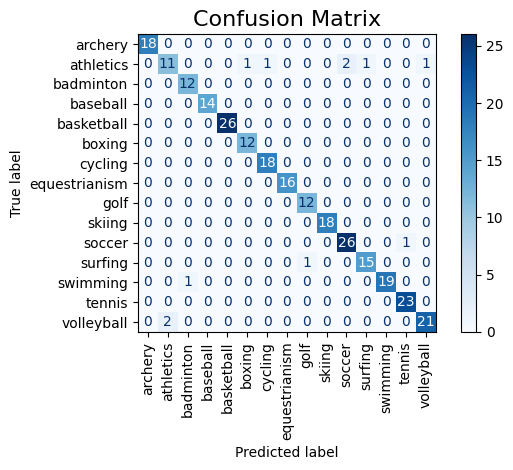

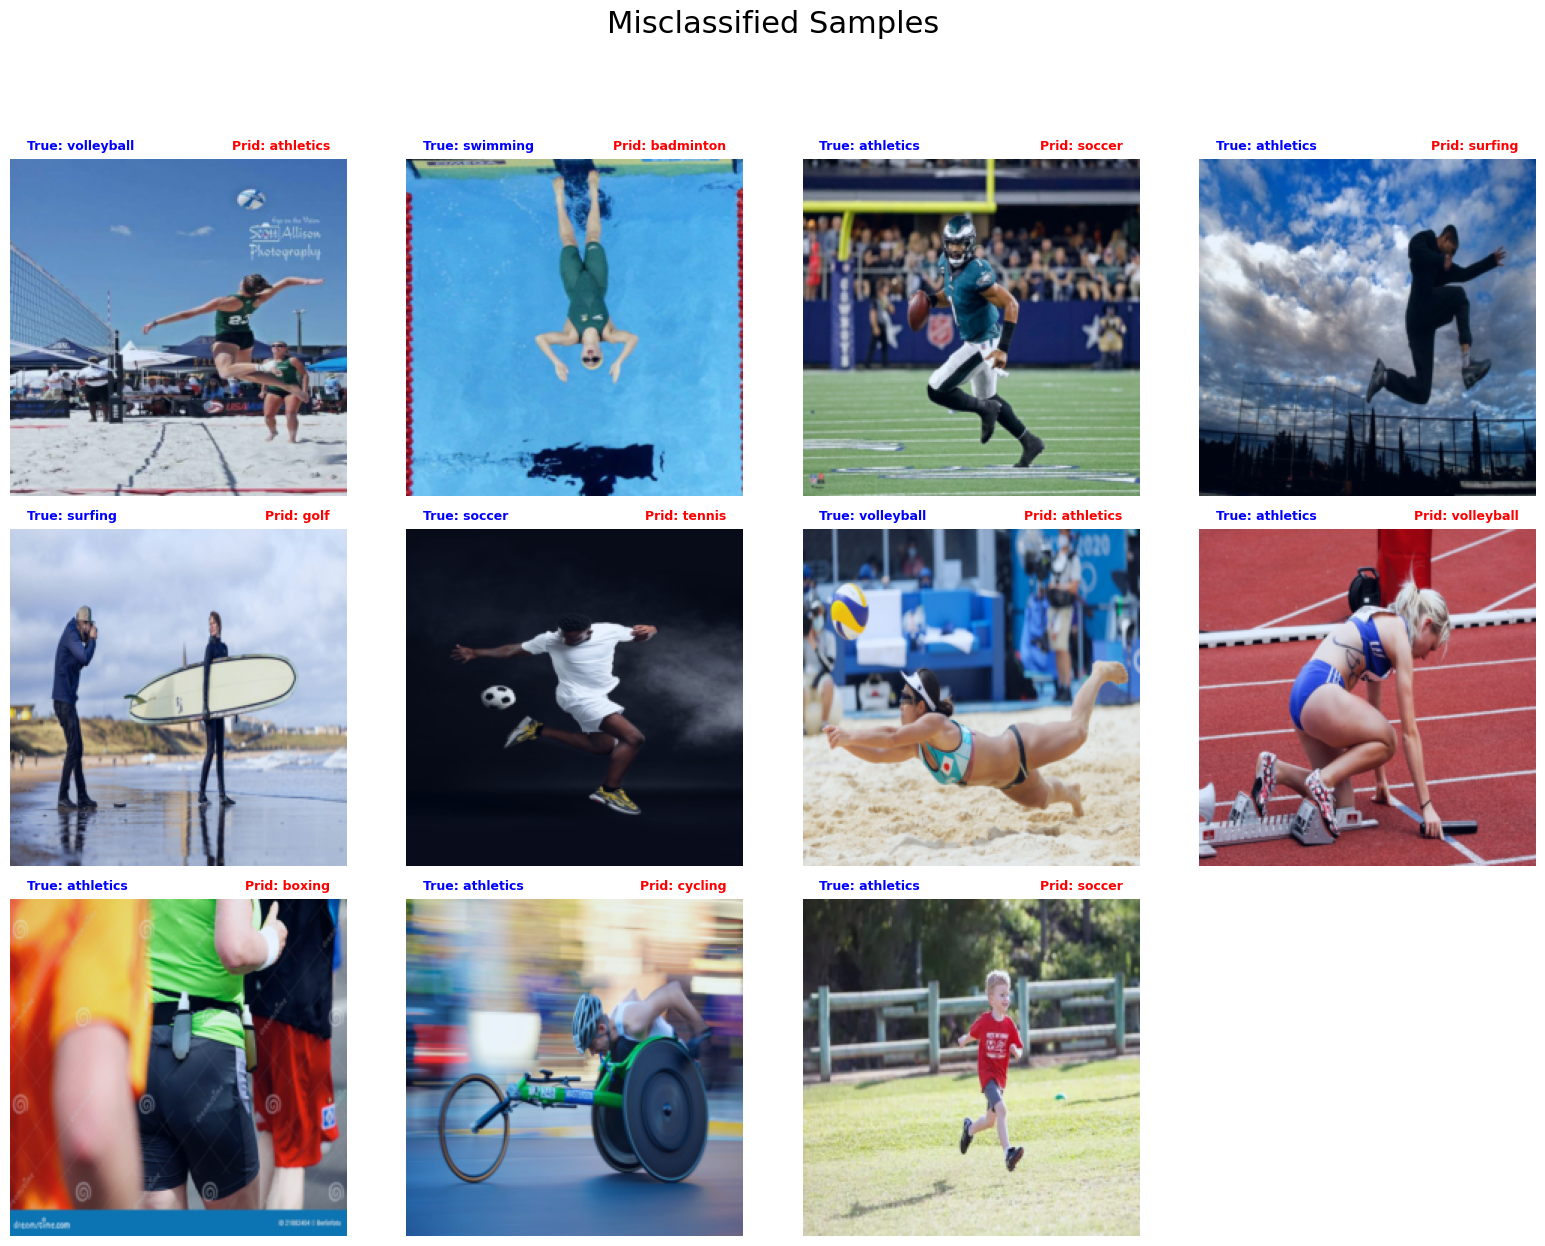

In [7]:
evaluate_model(model, test_loader, device, class_names=class_names, show_misclassified=True, max_misclassified=16)